<a href="https://colab.research.google.com/github/holly-hewitt/Abnormal-Infant-Movement-Detection/blob/main/Final/Trial%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


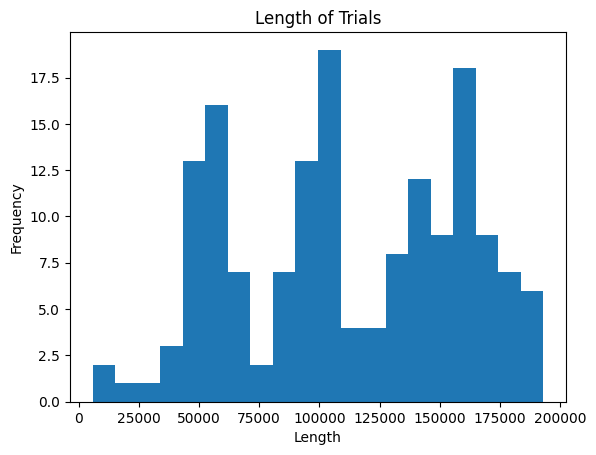

In [1]:
# import libraries
#import tensorflow.compat.v1 as tf
#tf.enable_eager_execution(tf.ConfigProto(log_device_placement=True))
#tf.test.gpu_device_name()
#tf.config.run_functions_eagerly(True)

#!pip install optuna
#!pip install optuna-integration

import tensorflow as tf
# Standard library imports
import datetime
import pickle
import gc

# Third-party imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.preprocessing import StandardScaler



# Keras/TensorFlow imports
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Conv1D, Dense, Dropout, Flatten, MaxPooling1D, Normalization
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.regularizers import l2


tf.get_logger().setLevel('ERROR')

from google.colab import drive
drive.mount('/content/drive')

# open accelData pickle
with open('drive/MyDrive/Pickles/accelData.pickle', 'rb') as handle:
    accelData = pickle.load(handle)

# Remove time column from accelData Measurements
for i in range(len(accelData['Measurements'])):
    accelData['Measurements'][i] = accelData['Measurements'][i].iloc[:, 1:]

# Necessary imports
import numpy as np
import matplotlib.pyplot as plt
for i in range(1):
    K = 14

    # Split some of the longer trials in half
    numRowsAccel = [df.shape[0] for df in accelData['Measurements']]
    sortedIndices = np.argsort(numRowsAccel)

    # Get the indices of the top k dataframes
    topKIndices = sortedIndices[-K:]

    # Get the top k dataframes
    topKDataframes = [accelData['Measurements'][i] for i in topKIndices]

    # Get the top k corresponding months, IDs, labels
    topKMonths = [accelData['Month'][i] for i in topKIndices]
    topKCodes = [accelData['Code'][i] for i in topKIndices]
    topKAbnormal = [accelData['Abnormal'][i] for i in topKIndices]
    topKAIMS = [accelData['AIMS'][i] for i in topKIndices]
    topKOptimality = [accelData['Optimality'][i] for i in topKIndices]

    # Remove the dataframes from accelData
    for i in sorted(topKIndices, reverse=True):
        del accelData['Measurements'][i]
        del accelData['Month'][i]
        del accelData['Code'][i]
        del accelData['Abnormal'][i]
        del accelData['AIMS'][i]
        del accelData['Optimality'][i]

    # Split the top k dataframes into two and reinsert into structure
    for i in range(len(topKDataframes)):
        df = topKDataframes[i]
        month = topKMonths[i]
        code = topKCodes[i]
        abnormal = topKAbnormal[i]
        aims = topKAIMS[i]
        optimality = topKOptimality[i]

        first_half = df.iloc[0:df.shape[0]//2]
        second_half = df.iloc[df.shape[0]//2:df.shape[0]]

        # Append the first and second halves to accelData
        accelData['Measurements'].append(first_half)
        accelData['Measurements'].append(second_half)

        # Append the corresponding values for month, code, abnormal, aims, and optimality
        accelData['Month'].extend([month, month])
        accelData['Code'].extend([code, code])
        accelData['Abnormal'].extend([abnormal, abnormal])
        accelData['AIMS'].extend([aims, aims])
        accelData['Optimality'].extend([optimality, optimality])

    # PLot histogram of length of trials
    lengths = [len(accelData['Measurements'][i]) for i in range(len(accelData['Measurements']))]
    plt.hist(lengths, bins=20)
    plt.title("Length of Trials")
    plt.xlabel("Length")
    plt.ylabel("Frequency")
    plt.show()

    # Memory management
    del numRowsAccel, sortedIndices, topKIndices, topKDataframes, topKMonths, topKCodes, topKAbnormal, topKAIMS, topKOptimality, first_half, second_half, df, month, code, abnormal, aims, optimality

# start making visualizations of the data.
try:
    i = accelData['Abnormal'].index(0.5)

    del accelData['Measurements'][i], accelData['Month'][i], accelData['Code'][i], accelData['Abnormal'][i], accelData['AIMS'][i], accelData['Optimality'][i]
except:
    pass


# get specific rows from dataframes in accelData Measurements
RA_cols = ['AccXRA', 'AccYRA', 'AccZRA']
LA_cols = ['AccXLA', 'AccYLA', 'AccZLA']
RW_cols = ['AccXRW', 'AccYRW', 'AccZRW']
LW_cols = ['AccXLW', 'AccYLW', 'AccZLW']


sum_cols = ['AccSumRA', 'AccSumLA', 'AccSumRW', 'AccSumLW']

#sum = [df[sum_cols] for df in accelData['Measurements']]

abnormal = accelData['Abnormal']
AIMS = accelData['AIMS']
Optimality = accelData['Optimality']
measurements = accelData['Measurements']
months = accelData['Month']
codes = accelData['Code']


measurements_nosum_cols = ['AccXRA', 'AccYRA', 'AccZRA', 'AccXLA', 'AccYLA', 'AccZLA', 'AccXRW', 'AccYRW', 'AccZRW', 'AccXLW', 'AccYLW', 'AccZLW']
measurements_nosum = [df[measurements_nosum_cols] for df in accelData['Measurements']]

del accelData

In [2]:
standardised = []
for df in measurements_nosum:
    scaler = StandardScaler()
    array = scaler.fit_transform(df)
    standardised_df = pd.DataFrame(array, columns=df.columns, index=df.index)
    standardised.append(standardised_df)

normalised = []
for df in measurements_nosum:
    scaler = MinMaxScaler()
    array = scaler.fit_transform(df)  # Fit and transform the data
    normalised_df = pd.DataFrame(array, columns=df.columns, index=df.index)  # Create a new DataFrame
    normalised.append(normalised_df)

In [3]:
# pad standardised data with zeros using keras.utils.pad_sequences

from keras.utils import pad_sequences

padded_standardised = pad_sequences(standardised, padding='post', value=0)
padded_normalised = pad_sequences(normalised, padding='post', value=0)


In [18]:
# Reduce size of padded_standardised and padded_normalised by mean smoothing and downsampling

smoothed_padded_standardised = []
for array in padded_standardised:
    # Convert numpy array to pandas DataFrame
    df = pd.DataFrame(array)

    # Apply mean smoothing
    smoothed_df = df.rolling(window=10).mean()

    # Fill NaN values with the original values (could consider other imputation methods as well)
    smoothed_df = smoothed_df.fillna(method='bfill').fillna(method='ffill')

    # Downsampler
    smoothed_df = smoothed_df.iloc[::10, :].reset_index(drop=True)

    # Convert DataFrame back to numpy array if needed
    smoothed_array = smoothed_df.to_numpy()

    smoothed_padded_standardised.append(smoothed_array)

print(smoothed_padded_standardised[0].shape)


(19301, 12)


In [15]:
# Testing clasification using crossfold validation
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, accuracy_score
from keras.layers import Masking, LSTM, SimpleRNN, Bidirectional, GRU

# Set the mixed precision policy
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

# define models
def create_CNN_model():
    model = Sequential()
    model.add(Masking(mask_value=0, input_shape=(padded_standardised[0].shape)))
    input_shape = padded_standardised[0].shape
   # Convolutional Layer 1
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))

    # Convolutional Layer 2
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))

    # Flattening the layers
    model.add(Flatten())

    # Dense Layer 1
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def create_LSTM_model():
    model = Sequential()
    model.add(Masking(mask_value=0, input_shape=(padded_standardised[0].shape)))

    # LSTM layer, does not return sequences to match the output shape
    model.add(LSTM(32, return_sequences=False, dropout=0.2, recurrent_dropout=0.2,
                   kernel_regularizer=l2(0.01)))
    # Output layer with sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid'))
    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])
    return model

def create_GRU_model():
    model = Sequential()
    model.add(Masking(mask_value=0, input_shape=(smoothed_padded_standardised[0].shape)))
    model.add(GRU(64, input_shape=(padded_standardised[0].shape)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def create_RNN_model():
    model = Sequential()
    model.add(SimpleRNN(32, input_shape=(padded_standardised[0].shape)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def train_model_with_gradient_accumulation(model, train_data, epochs=10, accumulation_steps=4):
    optimizer = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.BinaryCrossentropy()
    metrics = {'accuracy': tf.keras.metrics.BinaryAccuracy()}

    for epoch in range(epochs):
        print(f"\nStart of Epoch {epoch+1}")
        epoch_loss_avg = tf.keras.metrics.Mean()

        # Initialize gradient accumulation variables
        accumulated_gradients = [tf.zeros_like(var) for var in model.trainable_variables]

        for step, (x_batch_train, y_batch_train) in enumerate(train_data):
            with tf.GradientTape() as tape:
                logits = model(x_batch_train, training=True)
                loss_value = loss_fn(y_batch_train, logits) / accumulation_steps

            gradients = tape.gradient(loss_value, model.trainable_variables)
            accumulated_gradients = [(acc_grad + grad) for acc_grad, grad in zip(accumulated_gradients, gradients)]

            # Apply gradients if step is at accumulation step or last step
            if (step + 1) % accumulation_steps == 0 or step == len(train_data) - 1:
                optimizer.apply_gradients(zip(accumulated_gradients, model.trainable_variables))
                # Reset accumulated gradients after update
                accumulated_gradients = [tf.zeros_like(var) for var in model.trainable_variables]

            epoch_loss_avg.update_state(loss_value * accumulation_steps)  # Correct loss scaling
            metrics['accuracy'].update_state(y_batch_train, logits)

            if step % 10 == 0:
                print(f"Epoch {epoch+1}, Step {step}, Loss: {epoch_loss_avg.result().numpy()}, Accuracy: {metrics['accuracy'].result().numpy()}")

        print(f"Epoch {epoch+1} finished. Loss: {epoch_loss_avg.result().numpy()}, Accuracy: {metrics['accuracy'].result().numpy()}")
        metrics['accuracy'].reset_states()



# Assess model performance on data
def assess_model(train_data, model_fn, verbose=False):
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    str_codes = [str(x) for x in codes]
    unique_codes = np.unique(str_codes)

    fold = 0

    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    false_positive_rates = []
    specificity_scores = []

    for train_index, test_index in outer_cv.split(unique_codes):

        # Update progress
        fold += 1

        # Split data into train and test
        train_codes = unique_codes[train_index]
        test_codes = unique_codes[test_index]

        train_measurements = np.array([df for i, df in enumerate(train_data) if str_codes[i] in train_codes])
        test_measurements = np.array([df for i, df in enumerate(train_data) if str_codes[i] in test_codes])

        train_abnormal = np.array([abnormal for i, abnormal in enumerate(abnormal) if str_codes[i] in train_codes])
        test_abnormal = np.array([abnormal for i, abnormal in enumerate(abnormal) if str_codes[i] in test_codes])

        # Train the model
        model = model_fn()
        callbacks = [EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
        model.fit(train_measurements, train_abnormal, epochs=10, batch_size=1, callbacks=callbacks, validation_split=0.1)

        # Calculate metrics
        predictions = model.predict(test_measurements)
        tf.keras.backend.clear_session()
        gc.collect()

        accuracy = accuracy_score(test_abnormal, predictions.round())
        precision = precision_score(test_abnormal, predictions.round())
        recall = recall_score(test_abnormal, predictions.round())

        false_positives = np.logical_and(predictions > 0.5, test_abnormal == 0).sum()
        true_negatives = np.logical_and(predictions <= 0.5, test_abnormal == 0).sum()
        total_negatives = (test_abnormal == 0).sum()

        specificity = true_negatives / (true_negatives + false_positives)
        false_positive_rate = false_positives / (false_positives + true_negatives)

        if verbose:
            print("Results for fold:", fold)
            print(f"Accuracy: {accuracy}, Recall: {recall}, False Positives: {false_positive_rate}, Specificity: {specificity}, Precision: {precision}.")

        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        false_positive_rates.append(false_positive_rate)
        specificity_scores.append(specificity)

    # find average of each score
    avg_accuracy = np.mean(accuracy_scores)
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_false_positive_rate = np.mean(false_positive_rates)
    avg_specificity = np.mean(specificity_scores)

    if verbose:
        print("Results for all folds:")
        print(f"Accuracy: {avg_accuracy}, Recall: {avg_recall}, False Positive Rate: {avg_false_positive_rate}, Specificity: {avg_specificity}, Precision: {avg_precision}.")

    return avg_accuracy, avg_precision, avg_recall, avg_false_positive_rate, avg_specificity




In [19]:
GRU_results = assess_model(smoothed_padded_standardised, create_GRU_model, verbose=True)

Epoch 1/10
116/116 [==============================] - 1344s 12s/step - loss: 0.6596 - accuracy: 0.5948 - val_loss: 0.5461 - val_accuracy: 0.8462
Epoch 2/10
 12/116 [==>...........................] - ETA: 20:44 - loss: 0.5475 - accuracy: 0.8333

KeyboardInterrupt: 

In [5]:
CNN_test = assess_model(padded_standardised, create_CNN_model, verbose=True)

Epoch 1/10
116/116 [==============================] - 12s 47ms/step - loss: 107.0005 - accuracy: 0.5431 - val_loss: 0.3460 - val_accuracy: 0.8462
Epoch 2/10
116/116 [==============================] - 3s 27ms/step - loss: 6.1778 - accuracy: 0.7328 - val_loss: 5.4115 - val_accuracy: 0.8462
Epoch 3/10
116/116 [==============================] - 3s 28ms/step - loss: 5.7655 - accuracy: 0.7414 - val_loss: 0.4681 - val_accuracy: 0.8462
Epoch 4/10
116/116 [==============================] - 4s 32ms/step - loss: 1.9925 - accuracy: 0.6983 - val_loss: 0.6138 - val_accuracy: 0.8462


KeyboardInterrupt: 

In [ ]:
LSTM_results = assess_model(create_LSTM_model, verbose=True)

Epoch 1/10
  1/116 [..............................] - ETA: 7:15:52 - loss: 0.9720 - accuracy: 0.0000e+00

In [7]:
CNN_results = assess_model(create_CNN_model, verbose=True)

Epoch 1/10
116/116 [==============================] - 6s 29ms/step - loss: 112.5667 - accuracy: 0.5431 - val_loss: 18.3750 - val_accuracy: 0.8462
Epoch 2/10
116/116 [==============================] - 2s 19ms/step - loss: 14.6570 - accuracy: 0.7328 - val_loss: 2.8237 - val_accuracy: 0.8462
Epoch 3/10
116/116 [==============================] - 2s 17ms/step - loss: 0.6379 - accuracy: 0.7672 - val_loss: 3.6751 - val_accuracy: 0.8462
Epoch 4/10
116/116 [==============================] - 2s 18ms/step - loss: 2.6539 - accuracy: 0.7500 - val_loss: 2.9866 - val_accuracy: 0.8462
Epoch 5/10
1/1 [==============================] - 1s 1s/step
Results for fold: 1
Accuracy: 0.3870967741935484, Recall: 0.1111111111111111, False Positives: 0.16129032258064516, Specificity: 0.8387096774193549, Precision: 0.4.
Epoch 1/10
112/112 [==============================] - 5s 29ms/step - loss: 80.1792 - accuracy: 0.5446 - val_loss: 25.5770 - val_accuracy: 0.4615
Epoch 2/10
112/112 [==============================] -

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for fold: 2
Accuracy: 0.6857142857142857, Recall: 0.0, False Positives: 0.0, Specificity: 1.0, Precision: 0.0.
Epoch 1/10
109/109 [==============================] - 5s 28ms/step - loss: 149.1734 - accuracy: 0.5505 - val_loss: 98.4688 - val_accuracy: 0.3077
Epoch 2/10
109/109 [==============================] - 2s 20ms/step - loss: 32.3774 - accuracy: 0.6514 - val_loss: 3.6919 - val_accuracy: 0.6154
Epoch 3/10
109/109 [==============================] - 2s 20ms/step - loss: 1.7816 - accuracy: 0.6972 - val_loss: 0.4264 - val_accuracy: 0.6923
Epoch 4/10
109/109 [==============================] - 2s 18ms/step - loss: 1.7007 - accuracy: 0.6881 - val_loss: 0.5829 - val_accuracy: 0.6923
Epoch 5/10
109/109 [==============================] - 2s 18ms/step - loss: 6.9361 - accuracy: 0.7156 - val_loss: 0.4821 - val_accuracy: 0.6923
Epoch 6/10
2/2 [==============================] - 1s 214ms/step
Results for fold: 3
Accuracy: 0.6578947368421053, Recall: 0.5, False Positives: 0.3421052631578947

In [9]:
CNN_results = assess_model(create_CNN_model, verbose=True)

Epoch 1/10
116/116 [==============================] - 6s 30ms/step - loss: 92.0830 - accuracy: 0.6207 - val_loss: 52.4231 - val_accuracy: 0.8462
Epoch 2/10
116/116 [==============================] - 3s 23ms/step - loss: 29.6752 - accuracy: 0.6552 - val_loss: 30.9231 - val_accuracy: 0.8462
Epoch 3/10
116/116 [==============================] - 3s 23ms/step - loss: 13.4238 - accuracy: 0.7414 - val_loss: 23.9736 - val_accuracy: 0.6923
Epoch 4/10
116/116 [==============================] - 3s 23ms/step - loss: 8.0575 - accuracy: 0.7414 - val_loss: 0.4659 - val_accuracy: 0.8462
Epoch 5/10
116/116 [==============================] - 3s 23ms/step - loss: 0.5042 - accuracy: 0.7500 - val_loss: 0.4619 - val_accuracy: 0.8462
Epoch 6/10
116/116 [==============================] - 3s 23ms/step - loss: 3.9805 - accuracy: 0.7759 - val_loss: 0.4084 - val_accuracy: 0.8462
Epoch 7/10
116/116 [==============================] - 3s 23ms/step - loss: 3.0433 - accuracy: 0.7586 - val_loss: 0.3147 - val_accuracy: 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
CNN_results = assess_model(create_CNN_model, verbose=True)

Epoch 1/10
116/116 [==============================] - 7s 45ms/step - loss: 254.5429 - accuracy: 0.5776 - val_loss: 39.8462 - val_accuracy: 0.8462
Epoch 2/10
116/116 [==============================] - 4s 31ms/step - loss: 120.0346 - accuracy: 0.7069 - val_loss: 4.6328 - val_accuracy: 0.7692
Epoch 3/10
116/116 [==============================] - 4s 32ms/step - loss: 13.4113 - accuracy: 0.7586 - val_loss: 0.5272 - val_accuracy: 0.8462
Epoch 4/10
116/116 [==============================] - 3s 28ms/step - loss: 8.0287 - accuracy: 0.7414 - val_loss: 0.5705 - val_accuracy: 0.8462
Epoch 5/10
116/116 [==============================] - 4s 31ms/step - loss: 14.8329 - accuracy: 0.7672 - val_loss: 0.2675 - val_accuracy: 0.8462
Epoch 6/10
116/116 [==============================] - 3s 28ms/step - loss: 0.4498 - accuracy: 0.8103 - val_loss: 0.5081 - val_accuracy: 0.8462
Epoch 7/10
116/116 [==============================] - 3s 28ms/step - loss: 0.4956 - accuracy: 0.7845 - val_loss: 0.5015 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
